# Repeating Every Assessment/Experiment With 2.5D Execution



##### <center> <i> <span style="color:green"> Before we start... </span> </i> </center>

As the title indicates, I'll be exploring results of using 2.5D classification, and comparing them with the replication of slices, in order to ascertain whether this approach is successful. 

Of course, these results will most likely be quite specific to my data set and methodologies, and will only represent a direct comparison and quality of my own methods.

In order to maintain consistent cross-analysis results contrasts, each experiment will retain its original train-test-validation split and ResNet setup (architecture, settings, etc.).

Additionally, I'll be avoiding some experimental comparisons, as they provided results that are guaranteed to be identical throughout both <span style="color:Blue"> 2D (represented in blue) </span> and <span style="color:teal"> 2.5D (represented in teal)</span> classification. For example, I will not be using HRCT as the test split, nor testing whether the pure or conservative approach is best for best epoch choice. 

Still, all of this implies several code replications and re-executions. For this reason, I chose to display results in the form of a small report, with indexes and numbered titles, in order to facilitate comprehension and analysis.

# Table of Contents

- [1. Data Augmentation vs No Augmentation](#1-data-augmentation-vs-no-augmentation)
  - [1.1 Concept Overview](#11-concept-overview)
  - [1.2 Data Augmentation vs No Augmentation](#13-25d-execution-of-data-augmentation-vs-no-augmentation)
    - <span style="color:Blue"> 2D execution </span>
    - <span style="color:teal"> 2.5D execution </span>

  - [1.3 Threshold Selection and Model Choice](#12-threshold-selection-and-model-choice)
  - [1.4 Comparison with 2D](#14-comparison-with-2d)

- [2. Patient-wise Classification Methods](#2-patient-wise-classification-methods)
  - [2.1 Concept Overview](#21-concept-overview)
  - [2.2 Patient-wise Classification Methods](#23-25d-execution-of-patient-wise-classification-methods)
    - <span style="color:teal"> 2.5D execution </span>
  - [2.3 Threshold Selection and Model Choice](#22-threshold-selection-and-model-choice)
  - [2.4 Comparison with 2D](#24-comparison-with-2d)

- [3. Slice-level Feature-wise Classification](#3-slice-level-feature-wise-classification)
  - [3.1 Concept Overview](#31-concept-overview)
  - [3.2 Slice-level Feature-wise Classification](#33-25d-execution-of-slice-level-feature-wise-classification)
    - <span style="color:teal"> 2.5D execution </span>
  - [3.3 Threshold Selection and Model Choice](#32-threshold-selection-and-model-choice)
  - [3.4 Comparison with 2D](#34-comparison-with-2d)


<span style="color:red"> Se for pior do que 2D em com e sem augmentation, tudo o que vem para baixo/dependente posso assumir que será pior também </span>

<a name="1-data-augmentation-vs-no-augmentation"></a>
## 1. Data Augmentation vs No Augmentation

This section will be dedicated to assess whether the 2.5D model can outperform the 2D model. In order to do so, the first step is to run both resnets with the same configuration, architecture and data split. (only because the original ResNet was only trained for 50 epochs, and is therefore not directly comparable).


<a name="11-concept-overview"></a>
### 1.1 Concept Overview  

For detailed information on augmentations, please refer to directory `3 - resnetTesting`.



<a name="13-25d-execution-of-data-augmentation-vs-no-augmentation"></a>
### 1.2 Data Augmentation vs No Augmentation  


The dictionary below will be used to save relevant metadata and models, with structure:

```py

results_aug["method"] = [best_epoch, train_loss, best_val_loss, model]

```

In [1]:
results_aug = {}

In [ ]:
# Instructions: type 0 → 2D Classification
from newDimUtils import *

import matplotlib.colors as mcolors

# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


<center> 

#### <span style="color:Blue"> 2D, no Augmentations </span>

</center>

In [12]:
class FibrosisDataset(Dataset):
        def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
            self.img_labels = pd.read_csv(annotations_file)
            self.img_dir = img_dir
            self.transform = transform
            self.target_transform = target_transform
            self.albumentations = albumentations
            self.gauss = gauss
            self.number_images = 0

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            # idx represents index
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            if not os.path.exists(img_path): print(f"Missing file: {img_path}")
            slice_id = self.img_labels.iloc[idx, 0]
            patient_id = getPatientID(slice_id)

            # Load the .npy file
            image = np.load(img_path)
            
            #image = read_image(img_path)
            label = self.img_labels.iloc[idx, 1]

            # Adds randomly selected gauss noise or blur
            if self.gauss:
                # Gaussian Noise
                gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
                # Gaussian Blur
                gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
                # Random Choice
                image = random.choice((gauss_noise,gauss_blur))

            # Guarantee compatibility
            if self.gauss or self.albumentations: image = image.astype(np.float32)

            # Applies necessary ResNet input transformations
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            
            return image, label, patient_id

In [13]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [14]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_24280\2775595112.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_

In [15]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [16]:
# Save to dict for result comparison
results_aug["2d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:Blue"> 2D, with Augmentations </span>

</center>

In [17]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [18]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_24280\3071961570.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_

In [19]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [20]:
# Save to dict for result comparison
results_aug["2d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:teal"> 2.5D, no Augmentations </span>

</center>

In [24]:
class FibrosisDataset(Dataset):
        def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
            self.img_labels = pd.read_csv(annotations_file)
            self.img_dir = img_dir
            self.transform = transform
            self.target_transform = target_transform
            self.albumentations = albumentations
            self.gauss = gauss
            self.number_images = 0

        def __len__(self):
            return len(self.img_labels)
        

        def __getitem__(self, idx):
            # idx represents index

            # Locates each image in the csv file
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            if not os.path.exists(img_path): print(f"Missing file: {img_path}")

            # Fetches entire slice name
            slice_id = self.img_labels.iloc[idx, 0]

            # Parses patient ID for each slice
            patient_id = getPatientID(slice_id)

            # Get current slice info and class
            curr_img = np.load(img_path)
            label = self.img_labels.iloc[idx, 1]


            # This function can fetch any additional slice
            def load_image(i):
                row = self.img_labels.iloc[i]
                path = os.path.join(self.img_dir, row[0])
                img = np.load(path).astype(np.float32)
                label = row[1]
                return img, label, row[0]

            
            # Fetches previous slice
            if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
                prev_img, _, _ = load_image(idx - 1)
            else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
            
            # Try to get next slice
            if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
                next_img, _, _ = load_image(idx + 1)
            else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
            

            # Finally, stacks them into RGB: shape → (3, H, W)
            image = np.stack([prev_img, curr_img, next_img], axis=0)

            # Reorder: shape → (H, W, 3)
            image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

            # Adds randomly selected gauss noise or blur
            if self.gauss:
                # Gaussian Noise
                gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
                # Gaussian Blur
                gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
                # Random Choice
                image = random.choice((gauss_noise,gauss_blur))

            # Guarantee compatibility
            if self.gauss or self.albumentations: image = image.astype(np.float32)

            # Applies necessary ResNet input transformations
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            
            return image, label, patient_id

In [25]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [26]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2_5d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_24280\717346971.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_N

In [27]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [28]:
results_aug["2_5d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:teal"> 2.5D, with Augmentations </span>

</center>

In [29]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [30]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2_5d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_24280\2857014478.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_

In [33]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2_5D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2_5d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [32]:
# Save to dict for result comparison
results_aug["2_5d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<a name="12-threshold-selection-and-model-choice"></a>
### 1.3 Threshold Selection and Model Choice  



In [51]:
def getAllROCs(results_dict, val_dataset):
    threshold_dict = {}
    all_rocs = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    subplot_positions = {}

    for key in results_dict:
        # Determine row
        row = 1 if "2_5" in key else 0
        # Determine column
        col = 0 if ("no" in key or "No" in key) else 1
        subplot_positions[key] = (row, col)

    for key, value in tqdm(results_dict.items()):
        model = value[3]
        model.to(device)
        model.eval()

        all_labels, all_scores = [], []

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                probs = F.softmax(outputs, dim=1)[:, 1]

                all_scores.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        distances = np.sqrt((fpr) ** 2 + (1 - tpr) ** 2)
        best_idx = np.argmin(distances)
        best_threshold = thresholds[best_idx]

        threshold_dict[key] = best_threshold
        all_rocs[key] = (fpr, tpr, roc_auc, best_threshold, best_idx)

        # Subplot position
        row, col = subplot_positions[key]
        ax = axs[row][col]

        ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Threshold = {best_threshold:.2f}')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(key)
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Combined plot
    plt.figure(figsize=(8, 6))
    for key, (fpr, tpr, roc_auc, best_threshold, best_idx) in all_rocs.items():
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('All ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    return threshold_dict


In [ ]:
def darken_color(color, factor=0.7):
    """Darken a color by a given factor (0 to 1)."""
    rgb = mcolors.to_rgb(color)
    return tuple(np.clip([c * factor for c in rgb], 0, 1))

def plotAllLossCurves(results_dict):
    num_models = len(results_dict)
    plt.figure(figsize=(12, 10))

    # Individual subplots (2 rows × 2 cols)
    for idx, (key, values) in enumerate(results_dict.items()):
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        plt.subplot(2, 2, idx + 1)
        plt.plot(epochs, train_loss, label='Train Loss', linestyle='-', marker='o')
        plt.plot(epochs, val_loss, label='Val Loss', linestyle='--', marker='x')
        plt.plot(best_epoch, best_val_loss, 'X', color='purple', markersize=10, label='Best Epoch')

        plt.title(key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- Combined Plot -----
    plt.figure(figsize=(10, 6))

    # Use a predefined color cycle (can also use seaborn or matplotlib colormaps)
    color_cycle = plt.cm.tab10.colors  # 10 distinct colors
    keys = list(results_dict.keys())
    color_map = {key: color_cycle[i % len(color_cycle)] for i, key in enumerate(keys)}

    for key in keys:
        values = results_dict[key]
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        base_color = color_map[key]
        darker_color = darken_color(base_color)

        # Plot both curves in the same color
        plt.plot(epochs, train_loss, color=base_color, linestyle='-', alpha=0.6)
        plt.plot(epochs, val_loss, color=base_color, linestyle='--', alpha=0.9)

        # Plot the 'best epoch' as a darker marker
        plt.plot(best_epoch, best_val_loss, 'X', color=darker_color, markersize=10)

    # Add single legend entry per method
    for key in keys:
        plt.plot([], [], color=color_map[key], label=key)

    plt.title('All Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


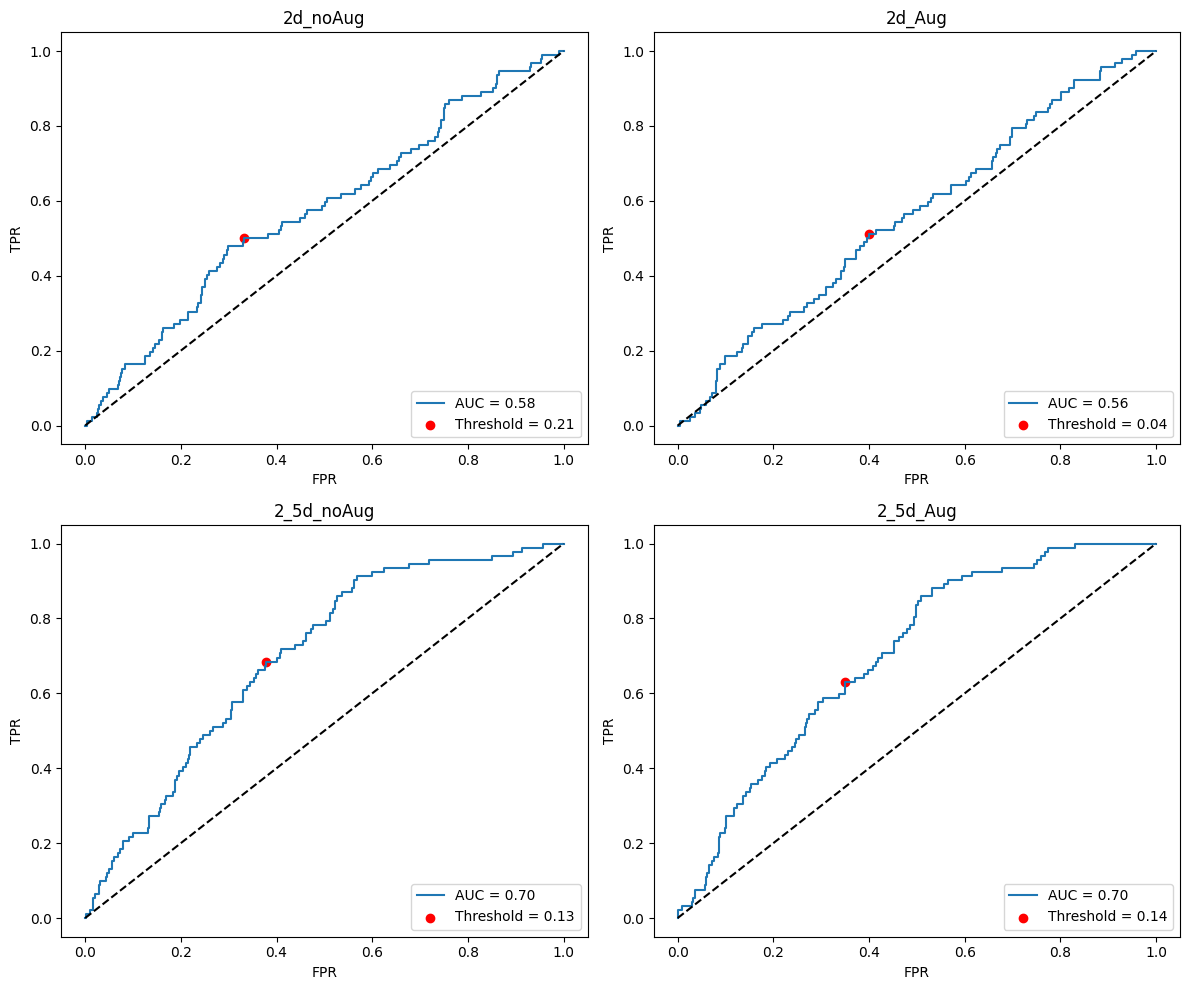

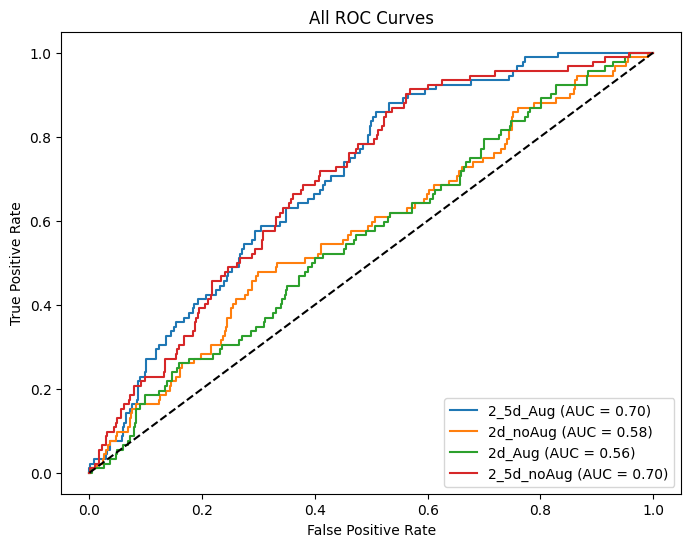

In [53]:
warnings.filterwarnings("ignore")

all_rocs = getAllROCs(results_aug, val_dataset)

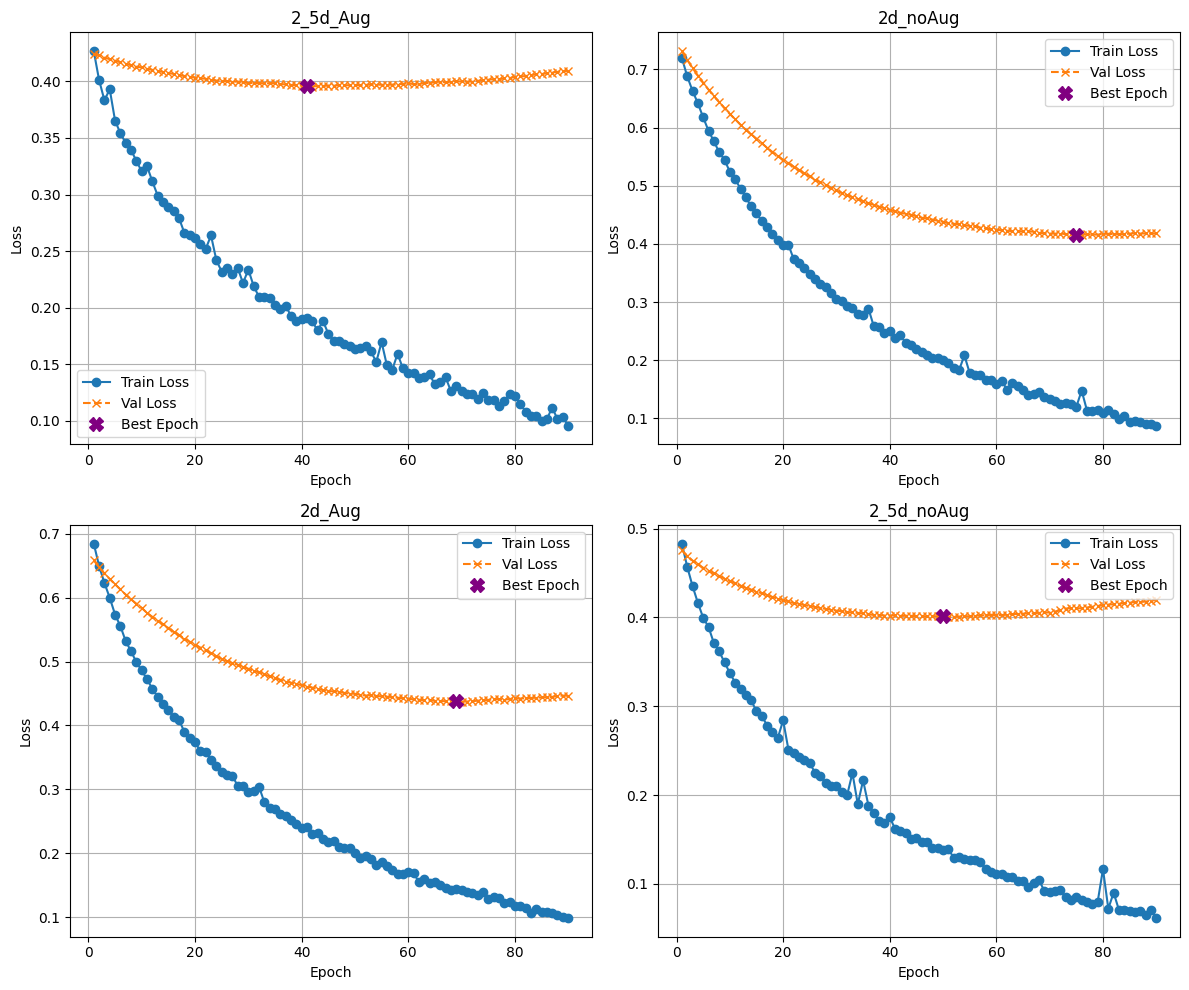

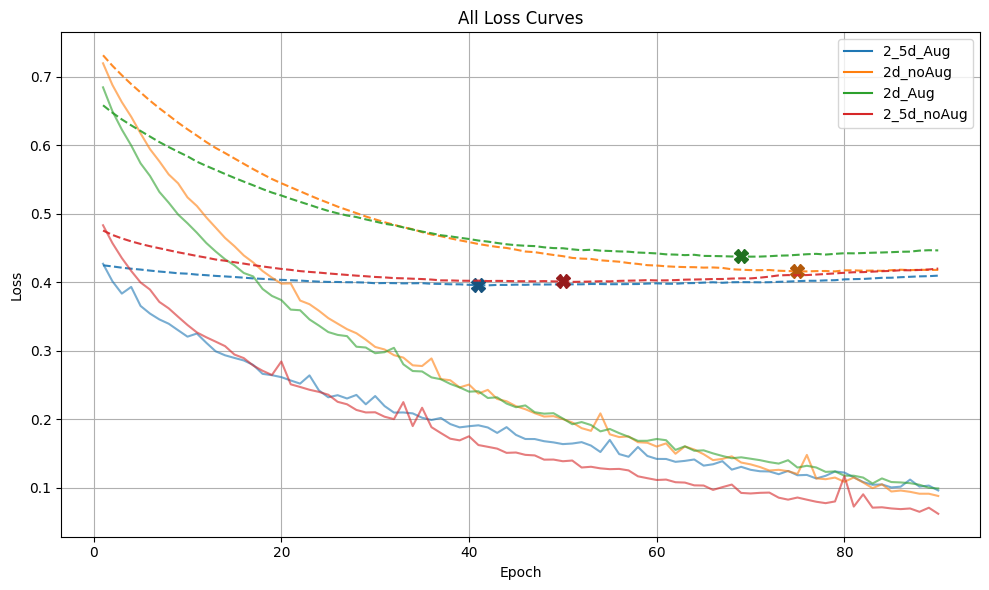

In [56]:
plotAllLossCurves(results_aug)


<a name="14-comparison-with-2d"></a>
### 1.4 Comparison with 2D  


<a name="2-patient-wise-classification-methods"></a>
## 2. Patient-wise Classification Methods

<a name="21-concept-overview"></a>
### 2.1 Concept Overview  

<a name="22-threshold-selection-and-model-choice"></a>
### 2.2 Threshold Selection and Model Choice  

<a name="23-25d-execution-of-patient-wise-classification-methods"></a>
### 2.3 Patient-wise Classification Methods  

<a name="24-comparison-with-2d"></a>
### 2.4 Comparison with 2D  


<a name="3-slice-level-feature-wise-classification"></a>
## 3. Slice-level Feature-wise Classification

<a name="31-concept-overview"></a>
### 3.1 Concept Overview  

<a name="32-threshold-selection-and-model-choice"></a>
### 3.2 Threshold Selection and Model Choice  

<a name="33-25d-execution-of-slice-level-feature-wise-classification"></a>
### 3.3 Slice-level Feature-wise Classification  

<a name="34-comparison-with-2d"></a>
### 3.4 Comparison with 2D  
